In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers , losses
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.layers import Dense , Dropout ,Input , Average , Flatten
from sklearn import metrics
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras import backend as K
from imgaug import augmenters
from keras import regularizers

# **Dataset For Simple AE and Denoising**

In [ ]:
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()

In [ ]:
x_train, x_val = train_test_split(x_train, test_size=0.2)
y_train, y_val = train_test_split(y_train, test_size=0.2)
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0
x_val=x_val.astype("float32")/255.0

In [ ]:
x_train=x_train.reshape((len(x_train),x_train.shape[1:][0]*x_train.shape[1:][1]))
x_test=x_test.reshape((len(x_test),x_test.shape[1:][0]*x_test.shape[1:][1]))
x_val=x_val.reshape((len(x_val),x_val.shape[1:][0]*x_val.shape[1:][1]))
print("Shape of x_train: ",x_train.shape)
print("Shape of x_test: ",x_test.shape)
print("Shape of x_test: ",x_val.shape)

Shape of x_train:  (48000, 784)
Shape of x_test:  (10000, 784)
Shape of x_test:  (12000, 784)


# **Simple AutoEncoder**

In [ ]:
#,activity_regularizer=regularizers.l1(10e-5)

In [ ]:
input_img=layers.Input(shape=(784,)) #Input Layer
encode1=layers.Dense(500,activation="relu")(input_img)
#encode1=layers.BatchNormalization()(encode1)
encode2=layers.Dense(200,activation="relu")(encode1)
#encode2=layers.BatchNormalization()(encode2)
encode3=layers.Dense(50,activation="relu")(encode2)
#encode3=layers.BatchNormalization()(encode3)
mid=layers.Dense(25,activation="sigmoid")(encode3)
#mid=layers.BatchNormalization()(mid)
decode1=layers.Dense(50,activation="relu")(mid)
#decode1=layers.BatchNormalization()(decode1)
decode2=layers.Dense(200,activation="relu")(decode1)
#decode2=layers.BatchNormalization()(decode2)
decode3=layers.Dense(500,activation="relu")(decode2)
#decode3=layers.BatchNormalization()(decode3)
output=layers.Dense(784,activation="sigmoid")(decode3)
autoencoder=Model(input_img,output) #sequential
autoencoder.compile(optimizer="adam",loss="mse")
es = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
hist=autoencoder.fit(x_train,x_train,epochs=50,batch_size=256,shuffle=True,validation_data=(x_train,x_train),callbacks=[es])

Epoch 1/50
188/188 [==============================] - 5s 12ms/step - loss: 0.0752 - val_loss: 0.0488
Epoch 2/50
188/188 [==============================] - 2s 9ms/step - loss: 0.0376 - val_loss: 0.0318
Epoch 3/50
188/188 [==============================] - 2s 9ms/step - loss: 0.0282 - val_loss: 0.0253
Epoch 4/50
188/188 [==============================] - 2s 10ms/step - loss: 0.0243 - val_loss: 0.0233
Epoch 5/50
188/188 [==============================] - 2s 11ms/step - loss: 0.0225 - val_loss: 0.0219
Epoch 6/50
188/188 [==============================] - 1s 8ms/step - loss: 0.0215 - val_loss: 0.0209
Epoch 7/50
188/188 [==============================] - 1s 8ms/step - loss: 0.0207 - val_loss: 0.0202
Epoch 8/50
188/188 [==============================] - 2s 8ms/step - loss: 0.0199 - val_loss: 0.0195
Epoch 9/50
188/188 [==============================] - 1s 7ms/step - loss: 0.0193 - val_loss: 0.0190
Epoch 10/50
188/188 [==============================] - 1s 7ms/step - loss: 0.0185 - val_loss: 0.0

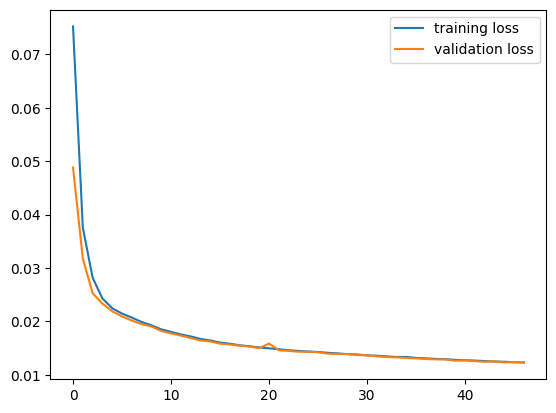

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show()

In [ ]:
encoder=Model(input_img,mid)
encoded_img=encoder.predict(x_test)
decoded_img=autoencoder.predict(x_test)

313/313 [==============================] - 1s 2ms/step


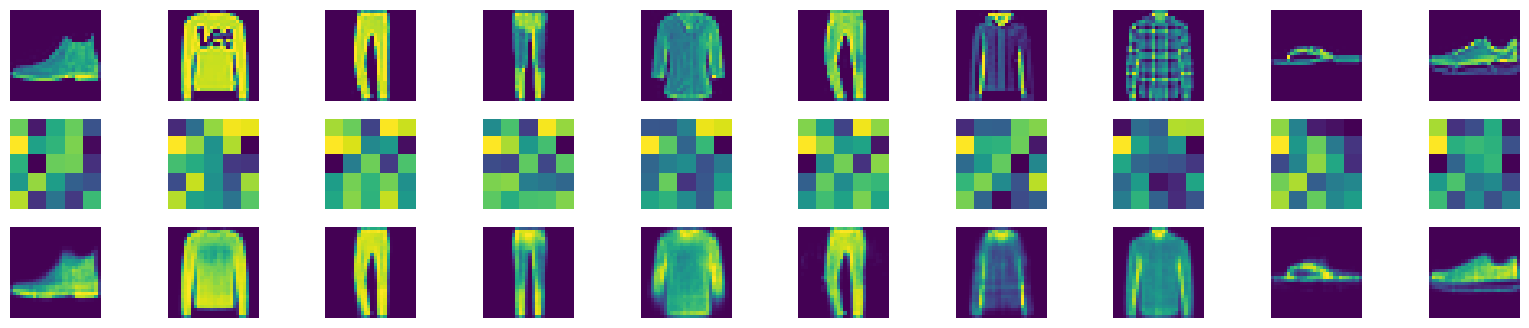

In [ ]:
#10 results
n=10
plt.figure(figsize=(20,4))
for i in range(n):
    #originals
    ax=plt.subplot(3,n,i+1)
    plt.imshow(x_test[i].reshape(28,28))
    plt.axis("off")

    #encoded
    ax=plt.subplot(3,n,n+i+1)
    plt.imshow(encoded_img[i].reshape(5,5))
    plt.axis("off")

    #results
    ax=plt.subplot(3,n,i+2*n+1)
    plt.imshow(decoded_img[i].reshape(28,28))
    plt.axis("off")
plt.show()

# **Denoising**

In [ ]:
# Lets add sample noise - Salt and Pepper
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

x_train_n = seq_object.augment_images(x_train * 255) / 255
x_val_n = seq_object.augment_images(x_val * 255) / 255
x_test_n = seq_object.augment_images(x_test * 255) / 255

In [ ]:
noise_factor = 0.5
x_train_n2 = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_val_n2 = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape)
x_test_n2 = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

In [ ]:
input_img=layers.Input(shape=(784,)) #Input Layer
encode1=layers.Dense(500,activation="relu")(input_img) #Encoder Layer with 32 units
encode2=layers.Dense(200,activation="relu")(encode1)
encode3=layers.Dense(50,activation="relu")(encode2)
mid=layers.Dense(16,activation="sigmoid")(encode3)
decode1=layers.Dense(50,activation="relu")(mid)
decode2=layers.Dense(200,activation="relu")(decode1)
decode3=layers.Dense(500,activation="relu")(decode2)
output=layers.Dense(784,activation="sigmoid")(decode3)
autoencoder=Model(input_img,output) #sequential
autoencoder.compile(optimizer="adam",loss="mse")

In [ ]:
hist=autoencoder.fit(x_train_n2,x_train,epochs=20,batch_size=256,shuffle=True,validation_data=(x_val_n2,x_val))

Epoch 1/20
188/188 [==============================] - 4s 8ms/step - loss: 0.0743 - val_loss: 0.0524
Epoch 2/20
188/188 [==============================] - 1s 8ms/step - loss: 0.0418 - val_loss: 0.0353
Epoch 3/20
188/188 [==============================] - 1s 7ms/step - loss: 0.0327 - val_loss: 0.0308
Epoch 4/20
188/188 [==============================] - 1s 6ms/step - loss: 0.0282 - val_loss: 0.0272
Epoch 5/20
188/188 [==============================] - 1s 8ms/step - loss: 0.0261 - val_loss: 0.0259
Epoch 6/20
188/188 [==============================] - 1s 8ms/step - loss: 0.0250 - val_loss: 0.0256
Epoch 7/20
188/188 [==============================] - 1s 8ms/step - loss: 0.0241 - val_loss: 0.0246
Epoch 8/20
188/188 [==============================] - 1s 6ms/step - loss: 0.0231 - val_loss: 0.0239
Epoch 9/20
188/188 [==============================] - 1s 6ms/step - loss: 0.0223 - val_loss: 0.0232
Epoch 10/20
188/188 [==============================] - 1s 6ms/step - loss: 0.0216 - val_loss: 0.0230

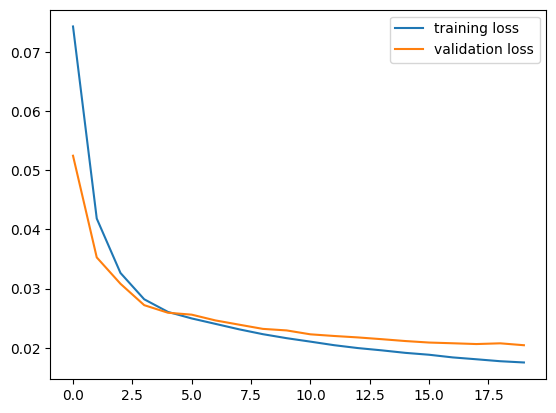

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show()

In [ ]:
encoder=Model(input_img,mid)
encoded_img=encoder.predict(x_test_n2)
decoded_img=autoencoder.predict(x_test_n2)

313/313 [==============================] - 1s 2ms/step


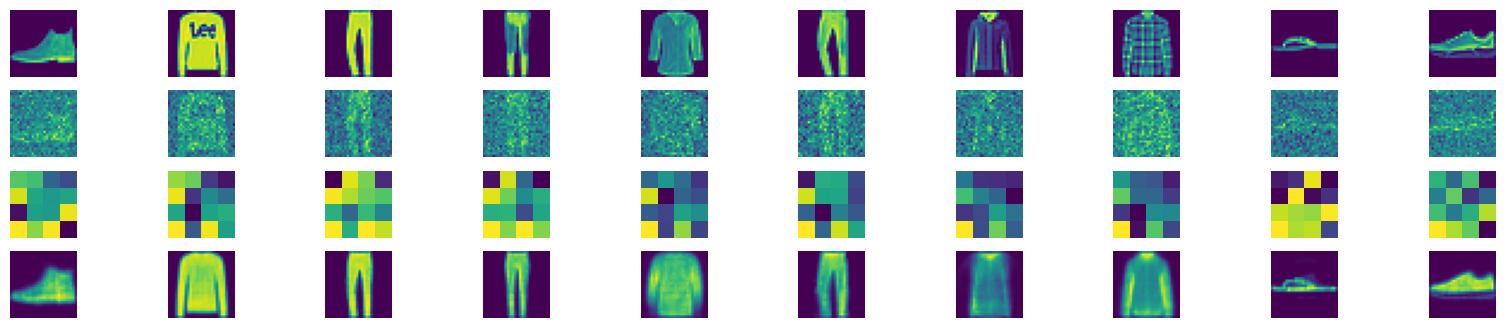

In [ ]:
#10 results
n=10
plt.figure(figsize=(20,4))
for i in range(n):
    #originals
    ax=plt.subplot(4,n,i+1)
    plt.imshow(x_test[i].reshape(28,28))
    plt.axis("off")

    #noisy
    ax=plt.subplot(4,n,n+i+1)
    plt.imshow(x_test_n2[i].reshape(28,28))
    plt.axis("off")

    #encoded
    ax=plt.subplot(4,n,2*n+i+1)
    plt.imshow(encoded_img[i].reshape(4,4))
    plt.axis("off")

    #results
    ax=plt.subplot(4,n,i+3*n+1)
    plt.imshow(decoded_img[i].reshape(28,28))
    plt.axis("off")
plt.show()

# **VAE**

In [ ]:
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_2 (Flatten)            (None, 3136)         0           ['conv2d_3[0][0]']               
                                                                                            

In [ ]:
latent_inputs = keras.layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        289 

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 8s 9ms/step - loss: 370.5900 - reconstruction_loss: 313.0518 - kl_loss: 6.8810
Epoch 2/30
469/469 [==============================] - 4s 8ms/step - loss: 279.4486 - reconstruction_loss: 270.7085 - kl_loss: 6.4351
Epoch 3/30
469/469 [==============================] - 4s 9ms/step - loss: 272.9826 - reconstruction_loss: 266.3316 - kl_loss: 6.2776
Epoch 4/30
469/469 [==============================] - 4s 9ms/step - loss: 271.1511 - reconstruction_loss: 264.4720 - kl_loss: 6.2346
Epoch 5/30
469/469 [==============================] - 5s 11ms/step - loss: 269.5302 - reconstruction_loss: 263.1249 - kl_loss: 6.2136
Epoch 6/30
469/469 [==============================] - 4s 9ms/step - loss: 269.7029 - reconstruction_loss: 262.2639 - kl_loss: 6.2108
Epoch 7/30
469/469 [==============================] - 4s 8ms/step - loss: 267.3479 - reconstruction_loss: 261.6082 - kl_loss: 6.2032
Epoch 8/30
469/469 [==============================] - 4s 9ms/step - 

1/1 [==============================] - 0s 17ms/step


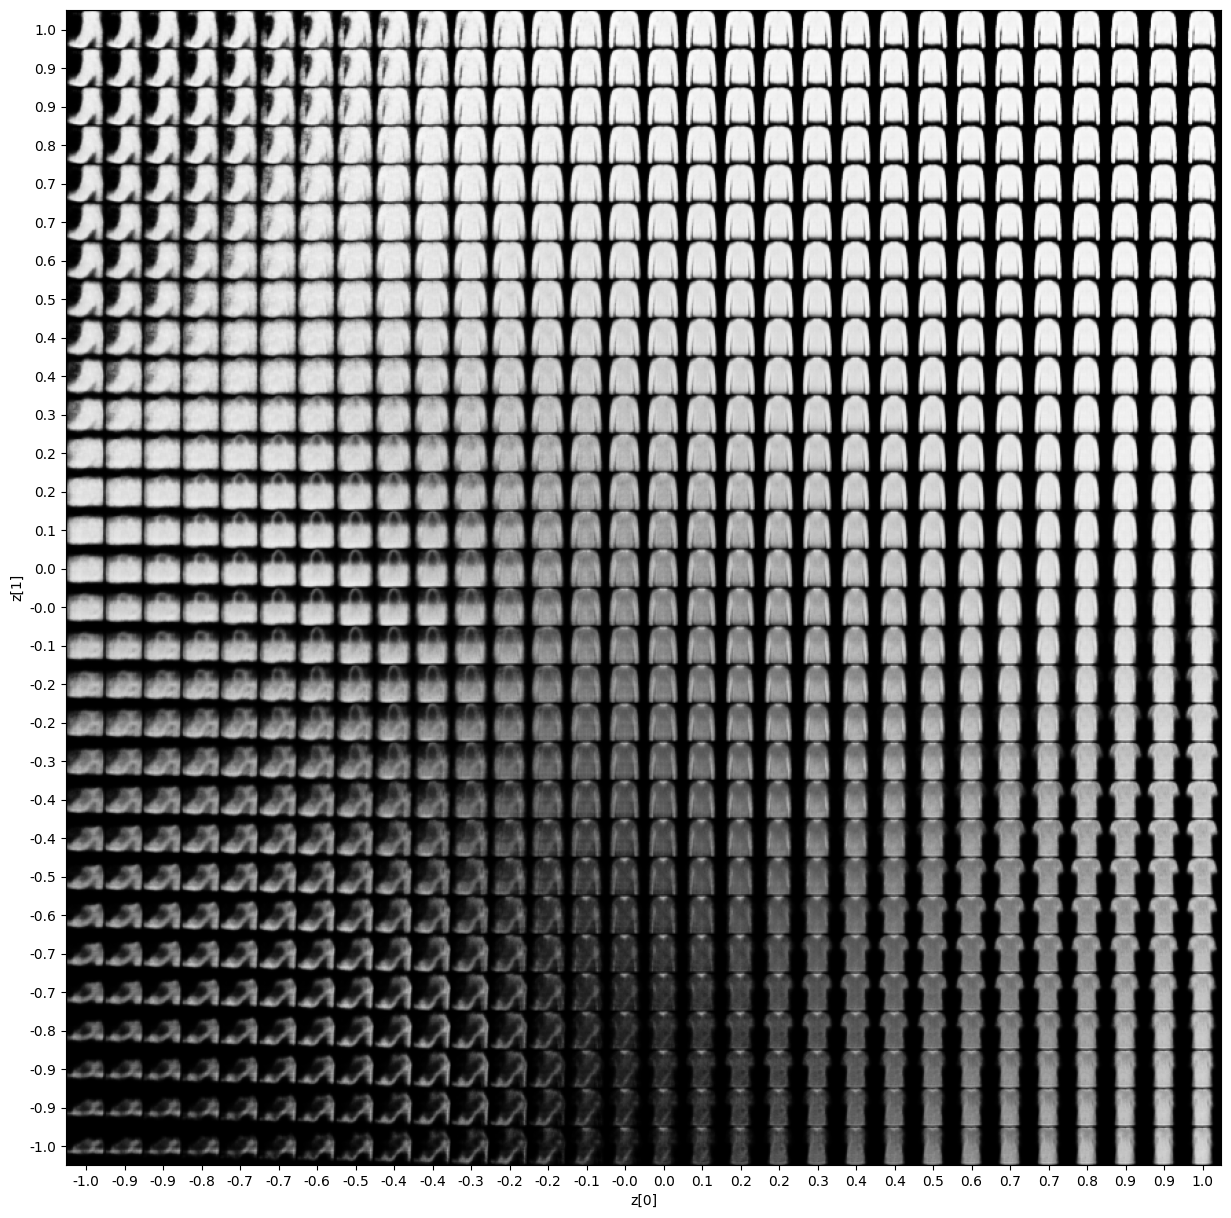

In [ ]:
def plot_latent_space(vae, n=30, figsize=15):
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

1875/1875 [==============================] - 3s 2ms/step


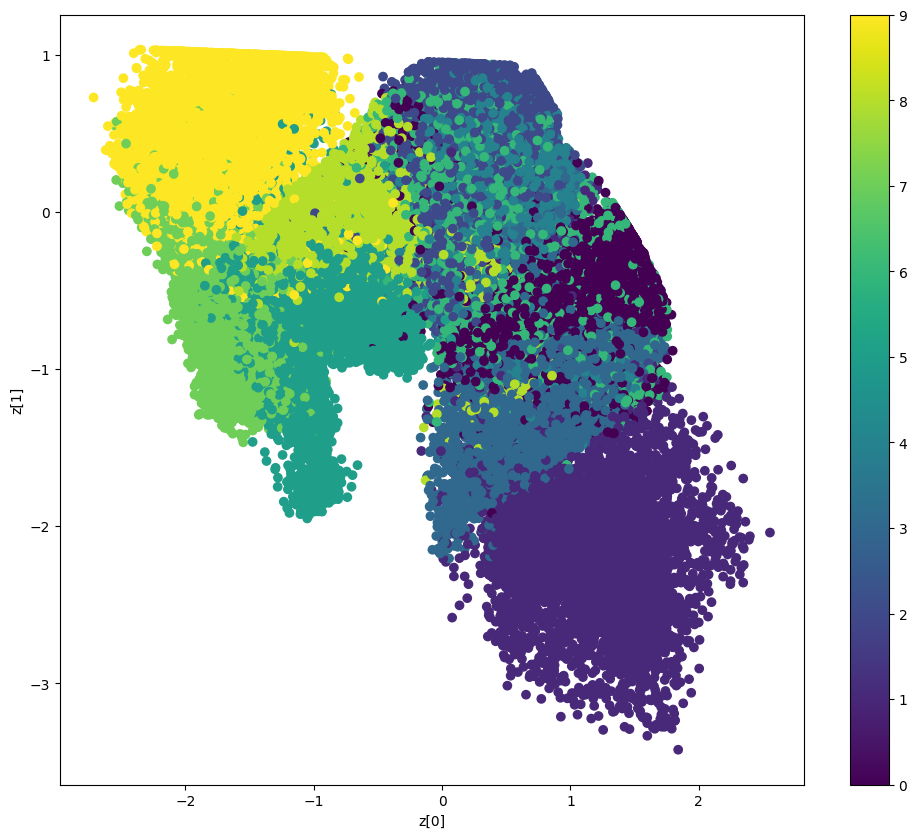

In [ ]:
def plot_label_clusters(vae, data, labels):
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(vae, x_train, y_train)

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
_,_,t = encoder.predict(x_train)
_, _,v = encoder.predict(x_test)

313/313 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step


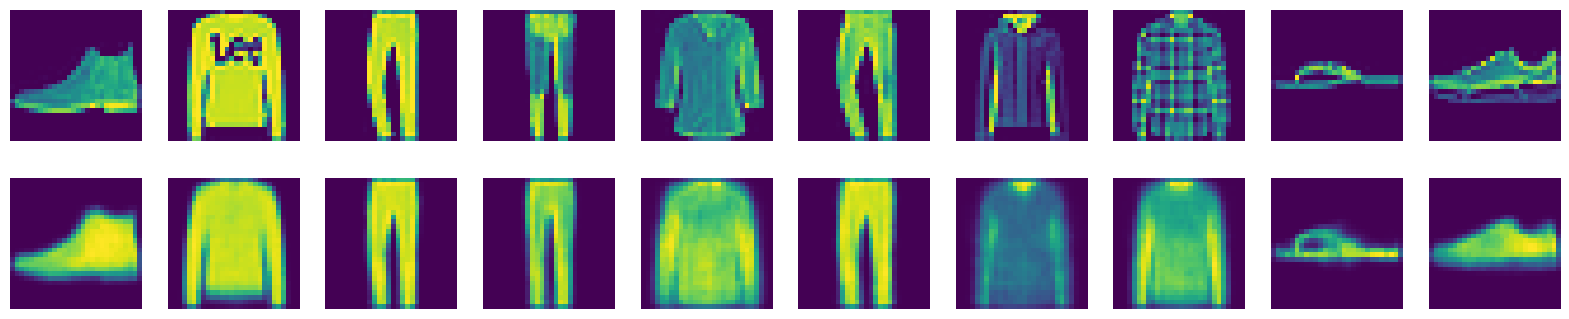

In [ ]:
new_images = decoder.predict(v)
#10 results
n=10
plt.figure(figsize=(20,4))
for i in range(n):
    #originals
    ax=plt.subplot(2,n,i+1)
    plt.imshow(x_test[i].reshape(28,28))
    plt.axis("off")

    #results
    ax=plt.subplot(2,n,i+n+1)
    plt.imshow(new_images[i].reshape(28,28))
    plt.axis("off")
plt.show()

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(2,1)))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

model.fit(x=t,
          y=y_train,
          epochs=30,
          batch_size = 32,
          validation_data=(v, y_test), verbose=1,
          callbacks=[early_stop],
          )

Epoch 1/30
1875/1875 [==============================] - 9s 4ms/step - loss: 0.9467 - accuracy: 0.6471 - val_loss: 0.8635 - val_accuracy: 0.6707
Epoch 2/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.8252 - accuracy: 0.6833 - val_loss: 0.8532 - val_accuracy: 0.6680
Epoch 3/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.8086 - accuracy: 0.6865 - val_loss: 0.8307 - val_accuracy: 0.6804
Epoch 4/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7994 - accuracy: 0.6882 - val_loss: 0.8296 - val_accuracy: 0.6845
Epoch 5/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.7918 - accuracy: 0.6925 - val_loss: 0.8356 - val_accuracy: 0.6788
Epoch 6/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7866 - accuracy: 0.6929 - val_loss: 0.8205 - val_accuracy: 0.6856
Epoch 7/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.7826 - accuracy: 0.6945 - val_loss: 0.8087 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(v, y_test)
print("test Accuracy : ", test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.8077 - accuracy: 0.6928
test Accuracy :  0.692799985408783


313/313 [==============================] - 1s 2ms/step


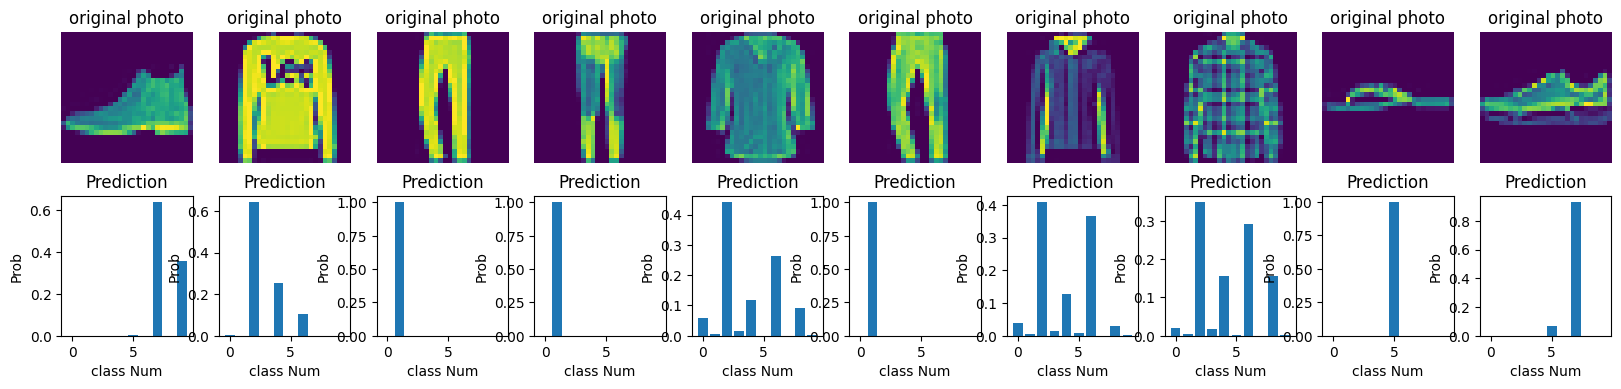

In [ ]:

predictions = model.predict(v)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].squeeze())
    plt.title("original photo")
    plt.axis("off")

    ax = plt.subplot(2, n, i + n + 1)
    plt.bar(range(10), predictions[i])
    plt.title("Prediction")
    plt.xlabel("class Num")
    plt.ylabel("Prob")
plt.show()
